# Fine-tune BLIP using Hugging Face `transformers`

## Set-up environment

In [ ]:
!pip install git+https://github.com/huggingface/transformers.git@main

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/huggingface/transformers.git (to revision main) to /tmp/pip-req-build-hc0ddl9x
  Running command git clone --filter=blob:none --quiet https://github.com/huggingface/transformers.git /tmp/pip-req-build-hc0ddl9x
  Resolved https://github.com/huggingface/transformers.git to commit 5f97bbc12469475b347c642a0f87474ceafecf45
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.1/200.1 kB 5.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 69.1 MB/s eta 0:00:00
  Created wheel for transformers: filename=transformers-4.29.0.dev0-py3-none-any.whl size=6934896 sha256=5e578e0e632dd8104894f80df1a5d9ca8f8663b3d3a6fa266d1b98ad894f914a
  Stored in directory: /tmp/pip-ephem-wheel-cache-ccccknum/wheels/b1/e5/2d/f924f6ef6b8b

## Load the image captioning dataset

Let's load the image captioning dataset, you just need few lines of code for that.

In [ ]:
!gdown --id 19PNUBURH4SMwqz4KZBwnACAMeKd7q_3Q

/usr/local/lib/python3.9/dist-packages/gdown/cli.py:121: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=19PNUBURH4SMwqz4KZBwnACAMeKd7q_3Q
To: /content/images.rar
100% 92.8M/92.8M [00:01<00:00, 56.7MB/s]


In [ ]:
!pip install unrar
!unrar x images.rar

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/

UNRAR 5.61 beta 1 freeware      Copyright (c) 1993-2018 Alexander Roshal


Extracting from images.rar

Creating    images                                                    OK
Extracting  images/286655408_203755458674310_8259357321063699530_nQ9PXSSBPVX6FA8K01LJS_12c1.jpg       0%  OK 
Extracting  images/301142740_573476357797051_1615591687230486641_nRJHNPVT2TOKR05JALV16_5579.jpg       0%  OK 
Extracting  images/304932228_3273881869595933_370777674431748799_nZP25V4N8DXS3FQYMJ1TF_f0a4.jpg       1%  OK 
Extracting  images/305006898_5836158639751120_8920968241470605159_n1PPTN3THPWPNDZ54N5E3_fea7.jpg       1%  OK 
Extracting  images/305034129_472320548136479_1597431188683411331_nN575G24JVQCYWD0FRNYD_a152.jpg       1%  OK 
Extracting  images/305161652_1535167873565957_330729006261760600_n0Z24RGVLX94060KBK5EY_d59c.jpg       2%  OK 
Extractin

Let's retrieve the caption of the first example:

And the corresponding image

## Create PyTorch Dataset

The lines below are entirely copied from the original notebook!

In [ ]:
import json
import pandas as pd


with open('/content/batch3.json', 'rt', encoding='utf-8-sig') as annotations:
    coco = json.load(annotations)
anns_img = pd.json_normalize(coco['images'])
anns_cat = pd.json_normalize(coco['categories'])
anns = pd.json_normalize(coco['annotations'])

In [ ]:
anns_cat[anns_cat['id'] == 0].iloc[0]['name']

,id,name
0,0,COAT
1,1,anklet
2,2,backpack
3,3,bag
4,4,belt
5,5,body
6,6,boot
7,7,bra
8,8,bracelet
9,9,chador


In [ ]:
anns_img

,width,height,id,file_name,url,caption
0,1080,1080,1,images/326487891_566693451748693_8719799379103...,http://cdn.charkh.io/cdn--1/20230123/326487891...,🎁 هر هفته یک برنده از بین لایک ها 🎁\nمانتو سوی...
1,1080,1080,2,images/326414127_106823292255137_3269113322437...,http://cdn.charkh.io/cdn--1/20230123/326414127...,🎁 هر هفته یک برنده از بین لایک ها 🎁\nست کراپ و...
2,1080,1080,3,images/326766987_431093662496326_6748482200342...,http://cdn.charkh.io/cdn--1/20230123/326766987...,🎁 هر هفته یک برنده از بین لایک ها 🎁\nست کراپ و...
3,1080,1080,4,images/326272698_1556752444797073_746409612966...,http://cdn.charkh.io/cdn--1/20230123/326272698...,🎁 هر هفته یک برنده از بین لایک ها 🎁\nست کراپ و...
4,1080,1080,5,images/326589340_984848922476022_5849443634377...,http://cdn.charkh.io/cdn--1/20230123/326589340...,🎁 هر هفته یک برنده از بین لایک ها 🎁\nست کراپ و...
...,...,...,...,...,...,...
474,1080,1346,475,images/326045826_117561157893511_5087215847964...,http://cdn.charkh.io/cdn--1/20230123/326045826...,aghakhanboutique \n➖➖➖➖➖ ➖ ➖\n دورس ،ضخیم، خوش...
475,1080,1350,476,images/325248977_873055487353019_2768164640890...,http://cdn.charkh.io/cdn--1/20230123/325248977...,aghakhanboutique \n➖➖➖➖➖ ➖ ➖\n دورس ،ضخیم، خوش...
476,1080,1350,477,images/326282834_159371786850612_5886264428454...,http://cdn.charkh.io/cdn--1/20230123/326282834...,aghakhanboutique \n➖➖➖➖➖ ➖ ➖\n دورس ،ضخیم، خوش...
477,1080,1350,478,images/325761234_731732541544557_6642292837409...,http://cdn.charkh.io/cdn--1/20230123/325761234...,aghakhanboutique \n➖➖➖➖➖ ➖ ➖\n دورس ،ضخیم، خوش...


In [ ]:
anns

,id,image_id,category_id,segmentation,bbox,ignore,iscrowd,area,is_for_sale,tags
0,1,1,32,"[[489.13548387096773, 80.82580645161292, 466.8...","[221.57419354838711, 58.52903225806451, 756.69...",0,0,416910.043348,1,"[{'key': 'model', 'value': 'زیپ دار'}, {'key':..."
1,2,2,34,"[[302.40000000000003, 147.71612903225807, 360....","[151.8967741935484, 147.71612903225807, 404.12...",0,0,82320.409573,1,"[{'key': 'model', 'value': 'استین کوتاه'}, {'..."
2,3,2,34,"[[799.8967741935484, 132.38709677419354, 713.4...","[657.7548387096774, 132.38709677419354, 405.52...",0,0,77528.581061,1,"[{'key': 'model', 'value': 'ست کراپ'}, {'key':..."
3,4,2,34,"[[546.2709677419357, 586.6838709677419, 413.88...","[413.88387096774187, 579.7161290322579, 425.03...",0,0,85291.634547,1,"[{'key': 'model', 'value': 'ست کراپ'}, {'key':..."
4,5,2,29,"[[266.1677419354839, 158.86451612903227, 250.8...","[68.28387096774196, 149.10967741935482, 243.87...",0,0,53942.298106,1,"[{'key': 'model', 'value': 'کشی'}, {'key': 'te..."
...,...,...,...,...,...,...,...,...,...,...
1510,1511,477,23,"[[409.45054945054943, 11.868131868131869, 118....","[44.5054945054945, 8.901098901098901, 996.9230...",0,0,835559.358773,1,"[{'key': 'model', 'value': 'ساده'}, {'key': 't..."
1511,1512,477,22,"[[308.5714285714286, 1056.2637362637365, 373.8...","[305.6043956043956, 1053.2967032967035, 501.42...",0,0,101215.765004,0,"[{'key': 'model', 'value': 'راسته'}, {'key': '..."
1512,1513,478,23,"[[412.4175824175824, 47.472527472527474, 166.1...","[14.835164835164836, 11.868131868131869, 996.9...",0,0,802639.475909,1,"[{'key': 'model', 'value': 'ساده'}, {'key': 't..."
1513,1514,478,22,"[[323.4065934065934, 1053.2967032967035, 400.5...","[270.0, 1029.5604395604396, 513.2967032967033,...",0,0,105507.366260,0,"[{'key': 'model', 'value': 'بوت کات'}, {'key':..."


In [ ]:
def change_file_names(x):
  x = x.split('/')[-1]
  return x

In [ ]:
x = pd.merge(anns, anns_img[['id', 'file_name']], left_on='image_id', right_on='id')[['id_x', 'image_id', 'tags', 'file_name', 'category_id']]
x = pd.merge(x, anns_cat, left_on='category_id', right_on='id')
x['file_name'] = x['file_name'].apply(change_file_names)
x['id_x'] = x['id_x'].map(str)
x['file_name'] = x.agg(lambda x: 'masks/'+ x['name'] + '/' + 'id_'+ x['id_x'] +'_' + x['file_name'], axis=1)


In [ ]:
x = pd.merge(anns, anns_img[['id', 'file_name']], left_on='image_id', right_on='id')[['id_x', 'image_id', 'tags', 'file_name', 'category_id']]

In [ ]:
x = pd.merge(x, anns_cat, left_on='category_id', right_on='id')

In [ ]:
x['file_name'] = x['file_name'].apply(change_file_names)

In [ ]:
x['id_x'] = x['id_x'].map(str)

In [ ]:
x['file_name'] = 'masks/'+ x['name'] + '/' + 'id_'+ x['id_x'] +'_' + x['file_name']

In [ ]:
x['file_name'] = x.agg(lambda x: 'masks/'+ x['name'] + '/' + 'id_'+ x['id_x'] +'_' + x['file_name'], axis=1)

In [ ]:
x.iloc[0].file_name

'masks/sweatshirt/id_1_326487891_566693451748693_8719799379103224624_n22OQ597OBDJ2MZ9LJLPG_aca5.jpg'

In [ ]:
x

,id_x,image_id,tags,file_name,category_id,id,name
0,1,1,"[{'key': 'model', 'value': 'زیپ دار'}, {'key':...",masks/sweatshirt/id_1_326487891_56669345174869...,32,32,sweatshirt
1,2,2,"[{'key': 'model', 'value': 'استین کوتاه'}, {'...",masks/t-shirt/id_2_326414127_106823292255137_3...,34,34,t-shirt
2,3,2,"[{'key': 'model', 'value': 'ست کراپ'}, {'key':...",masks/t-shirt/id_3_326414127_106823292255137_3...,34,34,t-shirt
3,4,2,"[{'key': 'model', 'value': 'ست کراپ'}, {'key':...",masks/t-shirt/id_4_326414127_106823292255137_3...,34,34,t-shirt
4,8,3,"[{'key': 'model', 'value': 'استین کوتاه'}, {'...",masks/t-shirt/id_8_326766987_431093662496326_6...,34,34,t-shirt
...,...,...,...,...,...,...,...
1510,1458,458,"[{'key': 'model', 'value': 'چهارخانه'}, {'key'...",masks/dress/id_1458_323729589_849389886352583_...,10,10,dress
1511,1459,458,"[{'key': 'model', 'value': 'چهارخانه'}, {'key'...",masks/dress/id_1459_323729589_849389886352583_...,10,10,dress
1512,1460,459,"[{'key': 'model', 'value': 'کوتاه'}, {'key': '...",masks/dress/id_1460_323800462_706172837786318_...,10,10,dress
1513,1461,460,"[{'key': 'model', 'value': 'کوتاه'}, {'key': '...",masks/dress/id_1461_323229639_894498871549309_...,10,10,dress


In [ ]:
area_dict = dict(zip(anns_cat.id, anns_cat.name))

In [ ]:
area_dict

{0: 'COAT',
 1: 'anklet',
 2: 'backpack',
 3: 'bag',
 4: 'belt',
 5: 'body',
 6: 'boot',
 7: 'bra',
 8: 'bracelet',
 9: 'chador',
 10: 'dress',
 11: 'earrings',
 12: 'glasses',
 13: 'glove',
 14: 'hat',
 15: 'hoodie',
 16: 'jacket',
 17: 'jumpsuit',
 18: 'luggage',
 19: 'manto',
 20: 'necklace',
 21: 'pancho',
 22: 'pants',
 23: 'pullover',
 24: 'ring',
 25: 'scarf',
 26: 'shirt',
 27: 'shoe',
 28: 'shomiz',
 29: 'shorts',
 30: 'skirt',
 31: 'socks',
 32: 'sweatshirt',
 33: 'swimsuit',
 34: 't-shirt',
 35: 'tie',
 36: 'top',
 37: 'underwear',
 38: 'vest',
 39: 'watch',
 40: 'wristlet'}

In [ ]:
x['file_name'] = area_dict[x['category_id']]+x['file_name'].strip('/')[-1]

In [ ]:
a = anns.apply(change_file_names)

In [ ]:
a

,id,image_id,category_id,segmentation,bbox,ignore,iscrowd,area,is_for_sale,tags
0,1,1,32,"[[489.13548387096773, 80.82580645161292, 466.8...","[221.57419354838711, 58.52903225806451, 756.69...",0,0,416910.043348,1,"[{'key': 'model', 'value': 'زیپ دار'}, {'key':..."
1,2,2,34,"[[302.40000000000003, 147.71612903225807, 360....","[151.8967741935484, 147.71612903225807, 404.12...",0,0,82320.409573,1,"[{'key': 'model', 'value': 'استین کوتاه'}, {'..."
2,3,2,34,"[[799.8967741935484, 132.38709677419354, 713.4...","[657.7548387096774, 132.38709677419354, 405.52...",0,0,77528.581061,1,"[{'key': 'model', 'value': 'ست کراپ'}, {'key':..."
3,4,2,34,"[[546.2709677419357, 586.6838709677419, 413.88...","[413.88387096774187, 579.7161290322579, 425.03...",0,0,85291.634547,1,"[{'key': 'model', 'value': 'ست کراپ'}, {'key':..."
4,5,2,29,"[[266.1677419354839, 158.86451612903227, 250.8...","[68.28387096774196, 149.10967741935482, 243.87...",0,0,53942.298106,1,"[{'key': 'model', 'value': 'کشی'}, {'key': 'te..."
...,...,...,...,...,...,...,...,...,...,...
1511,1512,477,22,"[[308.5714285714286, 1056.2637362637365, 373.8...","[305.6043956043956, 1053.2967032967035, 501.42...",0,0,101215.765004,0,"[{'key': 'model', 'value': 'راسته'}, {'key': '..."
1512,1513,478,23,"[[412.4175824175824, 47.472527472527474, 166.1...","[14.835164835164836, 11.868131868131869, 996.9...",0,0,802639.475909,1,"[{'key': 'model', 'value': 'ساده'}, {'key': 't..."
1513,1514,478,22,"[[323.4065934065934, 1053.2967032967035, 400.5...","[270.0, 1029.5604395604396, 513.2967032967033,...",0,0,105507.36626,0,"[{'key': 'model', 'value': 'بوت کات'}, {'key':..."
1514,1515,479,23,"[[436.1538461538462, 130.54945054945057, 332.3...","[50.43956043956044, 124.6153846153846, 958.351...",0,0,783474.725275,1,"[{'key': 'model', 'value': 'ساده'}, {'key': 't..."


In [ ]:
def concat_tags(tags):
  concat_str = ''
  for idx, i in enumerate(tags):
    if idx != len(tags)-1:
      concat_str += i['value']+','
    elif idx == len(tags)-1:
      concat_str += i['value']
  return concat_str

In [ ]:
x['tags'] =x['tags'].apply(concat_tags)

In [ ]:
x

,id_x,image_id,tags,file_name,category_id,id,name
0,1,1,"زیپ دار,کلاه دار,جیب دار,طرح بیجاری,کشمیر,وستر...",masks/sweatshirt/id_1_326487891_56669345174869...,32,32,sweatshirt
1,2,2,"استین کوتاه,نخ پنبه,راحتی و خانگی,دخترانه",masks/t-shirt/id_2_326414127_106823292255137_3...,34,34,t-shirt
2,3,2,"ست کراپ,استین کوتاه,ساده,نخ پنبه,راحتی و خانگ...",masks/t-shirt/id_3_326414127_106823292255137_3...,34,34,t-shirt
3,4,2,"ست کراپ,استین کوتاه,ساده,نخ پنبه,راحتی و خانگ...",masks/t-shirt/id_4_326414127_106823292255137_3...,34,34,t-shirt
4,8,3,"استین کوتاه,ساده,نخ پنبه,راحتی و خانگی,زنانه",masks/t-shirt/id_8_326766987_431093662496326_6...,34,34,t-shirt
...,...,...,...,...,...,...,...
1510,1458,458,"چهارخانه,نخ پنبه,اسپرت,زنانه",masks/dress/id_1458_323729589_849389886352583_...,10,10,dress
1511,1459,458,"چهارخانه,نخ پنبه,اسپرت,زنانه",masks/dress/id_1459_323729589_849389886352583_...,10,10,dress
1512,1460,459,"کوتاه,چهارخانه,استین دار,نخ پنبه,اسپرت,زنانه",masks/dress/id_1460_323800462_706172837786318_...,10,10,dress
1513,1461,460,"کوتاه,چهارخانه,نخ پنبه,اسپرت,زنانه",masks/dress/id_1461_323229639_894498871549309_...,10,10,dress


In [ ]:
anns.groupby('image_id').agg(lambda x: x.tolist())

,id,category_id,segmentation,bbox,ignore,iscrowd,area,is_for_sale,tags
image_id,,,,,,,,,
1,[1],[32],"[[[489.13548387096773, 80.82580645161292, 466....","[[221.57419354838711, 58.52903225806451, 756.6...",[0],[0],[416910.04334777594],[1],"[[{'key': 'model', 'value': 'زیپ دار'}, {'key'..."
2,"[2, 3, 4, 5, 6, 7]","[34, 34, 34, 29, 29, 29]","[[[302.40000000000003, 147.71612903225807, 360...","[[151.8967741935484, 147.71612903225807, 404.1...","[0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0]","[82320.40957336104, 77528.58106139395, 85291.6...","[1, 1, 1, 1, 1, 1]","[[{'key': 'model', 'value': 'استین کوتاه'}, {..."
3,"[8, 9, 10, 11, 12, 13, 14, 15]","[34, 34, 34, 34, 29, 29, 29, 29]","[[[235.50967741935483, 139.3548387096774, 309....","[[147.71612903225807, 139.3548387096774, 377.6...","[0, 0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0, 0]","[74689.41053069732, 71801.69057232048, 84971.2...","[1, 1, 1, 1, 0, 0, 0, 0]","[[{'key': 'model', 'value': 'استین کوتاه'}, {..."
4,"[16, 17]","[34, 29]","[[[515.6129032258065, 61.31612903225807, 427.8...","[[137.96129032258065, 43.2, 759.4838709677418,...","[0, 0]","[0, 0]","[246427.18501560832, 245084.30784599343]","[1, 1]","[[{'key': 'model', 'value': 'استین کوتاه'}, {..."
5,[18],[34],"[[[0.0, 157.4709677419355, 110.09032258064515,...","[[0.0, 58.52903225806451, 1061.883870967742, 1...",[0],[0],[859459.7486650194],[1],"[[{'key': 'model', 'value': 'استین کوتاه'}, {..."
...,...,...,...,...,...,...,...,...,...
475,"[1505, 1506, 1507, 1508]","[12, 23, 22, 27]","[[[542.0004478006878, 213.00000000000003, 491....","[[416.97246025768885, 208.0, 125.0279875429989...","[0, 0, 0, 0]","[0, 0, 0, 0]","[3379.7565592624014, 129844.95642256178, 87882...","[0, 1, 1, 0]","[[{'key': 'model', 'value': 'افتابی'}, {'key':..."
476,"[1509, 1510]","[23, 22]","[[[412.41758241758225, 23.736263736263737, 320...","[[41.53846153846154, 5.934065934065934, 979.12...","[0, 0]","[0, 0]","[788338.5400313959, 104697.46407438815]","[1, 0]","[[{'key': 'model', 'value': 'ساده'}, {'key': '..."
477,"[1511, 1512]","[23, 22]","[[[409.45054945054943, 11.868131868131869, 118...","[[44.5054945054945, 8.901098901098901, 996.923...","[0, 0]","[0, 0]","[835559.3587730937, 101215.76500422787]","[1, 0]","[[{'key': 'model', 'value': 'ساده'}, {'key': '..."


In [ ]:
import json
import pandas as pd


with open('batch3.json', 'rt', encoding='utf-8-sig') as f:
    coco = json.load(f)

with open('batch3_utf8.json', 'wt', encoding='UTF-8') as c_file:
        json.dump(coco, c_file, indent=4)

In [ ]:
b=np.ones((3,2,2))
b

array([[[1., 1.],
        [1., 1.]],

       [[1., 1.],
        [1., 1.]],

       [[1., 1.],
        [1., 1.]]])

In [ ]:
a=np.array([1,2,3])
a

array([1, 2, 3])

In [ ]:
broad_a = np.broadcast_to(a, b.T.shape).T
result = broad_a * b
print(result)


In [ ]:
coco=COCO(annFile)

In [ ]:
from pycocotools.coco import COCO
import os
from matplotlib import image
from pathlib import Path
from PIL import Image
import cv2
import numpy as np
from tqdm import tqdm

def extract_mask(annFile="./batch3_utf8.json", img_dir="./images"):
  coco=COCO(annFile)

  catIds = coco.getCatIds()
  annsIds = coco.getAnnIds()

  for cat in catIds:
      Path(os.path.join("./masks",coco.loadCats(cat)[0]['name'])).mkdir(parents=True, exist_ok=True)

  for ann in tqdm(annsIds):
      mask = coco.annToMask(coco.loadAnns(ann)[0])
      gt_bbox = coco.loadAnns(ann)[0]['bbox']

      file_path = os.path.join("./masks",coco.loadCats(coco.loadAnns(ann)[0]['category_id'])[0]['name'],'id_'+str(ann)+ '_' + coco.loadImgs(coco.loadAnns(ann)[0]['image_id'])[0]['file_name'].split('/')[-1])
      # image.imsave(file_path, mask)

      org = Image.open(coco.loadImgs(coco.loadAnns(ann)[0]['image_id'])[0]['file_name'])
      # print(coco.loadImgs(coco.loadAnns(ann)[0]['image_id'])[0]['file_name'])
      # print(file_path)
      mask = np.expand_dims(mask, axis=-1)
      masked_image = np.multiply(org, mask)
      # cropped_image = masked_image[int(gt_bbox[1]):int(gt_bbox[1]+gt_bbox[3]), int(gt_bbox[0]):int(gt_bbox[0]+gt_bbox[2]),  :]
      im = Image.fromarray(masked_image)
      im.save(file_path)
      # if ann == 4:
      #   break

In [ ]:
extract_mask()

loading annotations into memory...
Done (t=0.12s)
creating index...
index created!


100%|██████████| 1515/1515 [02:08<00:00, 11.81it/s]


In [ ]:
im = Image.open('./mask_name.png')
im

In [ ]:
anns

,id,image_id,category_id,segmentation,bbox,ignore,iscrowd,area,is_for_sale,tags
0,1,1,32,"[[489.13548387096773, 80.82580645161292, 466.8...","[221.57419354838711, 58.52903225806451, 756.69...",0,0,416910.043348,1,"[{'key': 'model', 'value': 'زیپ دار'}, {'key':..."
1,2,2,34,"[[302.40000000000003, 147.71612903225807, 360....","[151.8967741935484, 147.71612903225807, 404.12...",0,0,82320.409573,1,"[{'key': 'model', 'value': 'استین کوتاه'}, {'..."
2,3,2,34,"[[799.8967741935484, 132.38709677419354, 713.4...","[657.7548387096774, 132.38709677419354, 405.52...",0,0,77528.581061,1,"[{'key': 'model', 'value': 'ست کراپ'}, {'key':..."
3,4,2,34,"[[546.2709677419357, 586.6838709677419, 413.88...","[413.88387096774187, 579.7161290322579, 425.03...",0,0,85291.634547,1,"[{'key': 'model', 'value': 'ست کراپ'}, {'key':..."
4,5,2,29,"[[266.1677419354839, 158.86451612903227, 250.8...","[68.28387096774196, 149.10967741935482, 243.87...",0,0,53942.298106,1,"[{'key': 'model', 'value': 'کشی'}, {'key': 'te..."
...,...,...,...,...,...,...,...,...,...,...
1510,1511,477,23,"[[409.45054945054943, 11.868131868131869, 118....","[44.5054945054945, 8.901098901098901, 996.9230...",0,0,835559.358773,1,"[{'key': 'model', 'value': 'ساده'}, {'key': 't..."
1511,1512,477,22,"[[308.5714285714286, 1056.2637362637365, 373.8...","[305.6043956043956, 1053.2967032967035, 501.42...",0,0,101215.765004,0,"[{'key': 'model', 'value': 'راسته'}, {'key': '..."
1512,1513,478,23,"[[412.4175824175824, 47.472527472527474, 166.1...","[14.835164835164836, 11.868131868131869, 996.9...",0,0,802639.475909,1,"[{'key': 'model', 'value': 'ساده'}, {'key': 't..."
1513,1514,478,22,"[[323.4065934065934, 1053.2967032967035, 400.5...","[270.0, 1029.5604395604396, 513.2967032967033,...",0,0,105507.366260,0,"[{'key': 'model', 'value': 'بوت کات'}, {'key':..."


In [ ]:
len(anns)

1515

In [ ]:
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import json
import pandas as pd

class ImageCaptioningDataset(Dataset):
    def __init__(self, annotation, processor):
        with open(annotation, 'rt') as annotations:
            coco = json.load(annotations)
        self.anns_img = pd.json_normalize(coco['images'])
        self.anns_cat = pd.json_normalize(coco['categories'])
        self.anns = pd.json_normalize(coco['annotations'])
        self.dataset = self.preprocess_anns(self.anns)
        self.processor = processor

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        item = self.dataset.iloc[idx]
        img = Image.open(item['file_name'])
        encoding = self.processor(images=img, text=item["tags"], padding="max_length", return_tensors="pt")
        # remove batch dimension
        encoding = {k:v.squeeze() for k,v in encoding.items()}
        return encoding
    def change_file_names(self, x):
        x = x.split('/')[-1]
        return x
    def concat_tags(self, tags):
        concat_str = ''
        for idx, i in enumerate(tags):
          if idx != len(tags)-1:
            concat_str += i['value']+','
          elif idx == len(tags)-1:
            concat_str += i['value']
        return concat_str
    def preprocess_anns(self, anns):
        x = pd.merge(self.anns, self.anns_img[['id', 'file_name']], left_on='image_id', right_on='id')[['id_x', 'image_id', 'tags', 'file_name', 'category_id']]
        x = pd.merge(x, self.anns_cat, left_on='category_id', right_on='id')
        x['file_name'] = x['file_name'].apply(self.change_file_names)
        x['id_x'] = x['id_x'].map(str)
        x['file_name'] = x.agg(lambda x: 'masks/'+ x['name'] + '/' + 'id_'+ x['id_x'] +'_' + x['file_name'], axis=1)
        x['tags'] =x['tags'].apply(self.concat_tags)
        return x

In [ ]:
x = pd.merge(anns, anns_img[['id', 'file_name']], left_on='image_id', right_on='id')[['id_x', 'image_id', 'tags', 'file_name', 'category_id']]
x = pd.merge(x, anns_cat, left_on='category_id', right_on='id')
x['file_name'] = x['file_name'].apply(change_file_names)
x['id_x'] = x['id_x'].map(str)
x['file_name'] = x.agg(lambda x: 'masks/'+ x['name'] + '/' + 'id_'+ x['id_x'] +'_' + x['file_name'], axis=1)
x['tags'] = x['tags'].apply(concat_tags)

In [ ]:
x

## Load model and processor

In [ ]:
from transformers import AutoProcessor, BlipForConditionalGeneration

processor = AutoProcessor.from_pretrained("Salesforce/blip-image-captioning-base")
model = BlipForConditionalGeneration.from_pretrained("Salesforce/blip-image-captioning-base")

Now that we have loaded the processor, let's load the dataset and the dataloader:

In [ ]:
train_dataset = ImageCaptioningDataset('/content/batch3_utf8.json', processor)
train_dataloader = DataLoader(train_dataset, shuffle=True, batch_size=3)

In [ ]:
train_dataset

## Train the model

Let's train the model! Run the simply the cell below for training the model

In [ ]:
import torch

optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5)

device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

model.train()

for epoch in range(4):
  print("Epoch:", epoch)
  for idx, batch in enumerate(train_dataloader):
    input_ids = batch.pop("input_ids").to(device)
    pixel_values = batch.pop("pixel_values").to(device)

    outputs = model(input_ids=input_ids,
                    pixel_values=pixel_values,
                    labels=input_ids)
    
    loss = outputs.loss

    print("Loss:", loss.item())

    loss.backward()

    optimizer.step()
    optimizer.zero_grad()

Epoch: 0
Loss: 12.993825912475586
Loss: 10.162384986877441
Loss: 10.115485191345215
Loss: 10.061667442321777
Loss: 10.168922424316406
Loss: 10.040514945983887
Loss: 9.90412425994873
Loss: 10.007731437683105
Loss: 9.89932918548584
Loss: 9.493518829345703
Loss: 9.26826000213623
Loss: 9.043580055236816
Loss: 8.85744857788086
Loss: 8.639633178710938
Loss: 8.575592041015625
Loss: 8.319923400878906
Loss: 8.216238021850586
Loss: 8.127158164978027
Loss: 7.938072681427002
Loss: 7.733455181121826
Loss: 7.778863430023193
Loss: 7.544944763183594
Loss: 7.470998764038086
Loss: 7.272650718688965
Loss: 7.162236213684082
Loss: 7.045936107635498
Loss: 6.870984077453613
Loss: 6.961627960205078
Loss: 6.802375793457031
Loss: 6.613397121429443
Loss: 6.4741435050964355
Loss: 6.348142623901367
Loss: 6.246880531311035
Loss: 6.179826736450195
Loss: 5.995386600494385
Loss: 5.858437538146973
Loss: 5.8036417961120605
Loss: 5.625951290130615
Loss: 5.485297203063965
Loss: 5.40798282623291
Loss: 5.24379301071167
Loss

## Inference

Let's check the results on our train dataset

In [ ]:
train_dataset.dataset.iloc[327]['tags']

'راسته,زاپ دار,جین,وسترن و کابوی و سافاری,اسپرت,زنانه'

In [ ]:
from PIL import Image

image = Image.open(train_dataset.dataset.iloc[327]['file_name'])

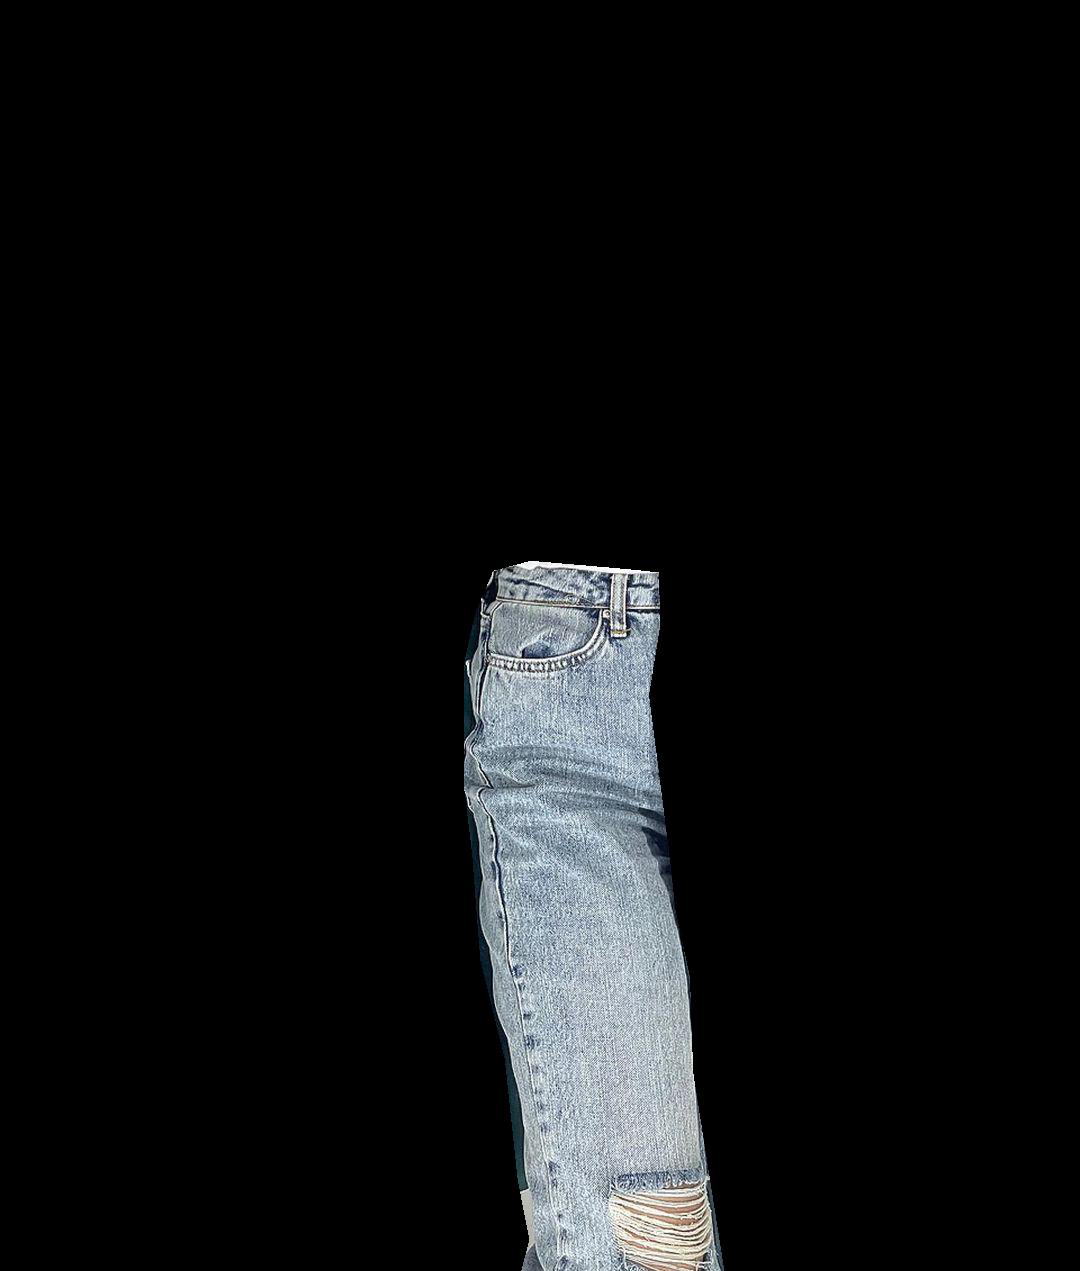

In [ ]:
image

In [ ]:
# prepare image for the model
inputs = processor(images=image, return_tensors="pt").to(device)
pixel_values = inputs.pixel_values

generated_ids = model.generate(pixel_values=pixel_values, max_length=50)
generated_caption = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]
print(generated_caption)

راسته, زاپ دار, جین, اسپرت, و بیسیک و روزمره, زنانه


## Load from the Hub

Once trained you can push the model and processor on the Hub to use them later. 
Meanwhile you can play with the model that we have fine-tuned!

In [ ]:
from transformers import BlipForConditionalGeneration, AutoProcessor

model = BlipForConditionalGeneration.from_pretrained("ybelkada/blip-image-captioning-base-football-finetuned").to(device)
processor = AutoProcessor.from_pretrained("ybelkada/blip-image-captioning-base-football-finetuned")

Downloading:   0%|          | 0.00/4.72k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/990M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/431 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/488 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/712k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/125 [00:00<?, ?B/s]

Let's check the results on our train dataset!

In [ ]:
from matplotlib import pyplot as plt

fig = plt.figure(figsize=(18, 14))

# prepare image for the model
for i, example in enumerate(dataset):
  image = example["image"]
  inputs = processor(images=image, return_tensors="pt").to(device)
  pixel_values = inputs.pixel_values

  generated_ids = model.generate(pixel_values=pixel_values, max_length=50)
  generated_caption = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]
  fig.add_subplot(2, 3, i+1)
  plt.imshow(image)
  plt.axis("off")
  plt.title(f"Generated caption: {generated_caption}")